In [1]:
from l2r_class import *

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Chargement json (Top documents les plus non-pertinents pour chaque requete selon le score BM25)

#### Loading from Ms Marco

In [3]:
import json

# Load the JSON data from a file
data_list = []
with open('msmarco-hard-negatives.jsonl', 'r') as file:
	for line in file:
		#print(json.loads(line))
		data_list.append(json.loads(line))
		if len(data_list) > 50:
			break

#### Création triplet

In [3]:
def create_triplet(data_list):
	# Now data_list contains multiple JSON objects, one per line from the file
	data_id = []

	for data in data_list:
		# Extract positive examples
		pos_examples = [(data['qid'], pos['pid'], 1) for i, pos in enumerate(data['pos']) if i < 1]

		# Extract negative examples with a bm25_score
		neg_examples = [(data['qid'], neg['pid'], 0) for i, neg in enumerate(data['neg']['bm25']) if i < 9]

		# Combine positive and negative examples
		data_id.extend(pos_examples + neg_examples)

	# Print the final_data
	print("data size", len(data_id))
	print(data_id[:20])
	return data_id

data_id = create_triplet(data_list)

data size 510
[('571018', '7349777', 1), ('571018', '6948601', 0), ('571018', '5129919', 0), ('571018', '6717931', 0), ('571018', '1065943', 0), ('571018', '1626276', 0), ('571018', '981824', 0), ('571018', '6449111', 0), ('571018', '1028927', 0), ('571018', '2524942', 0), ('832106', '5090093', 1), ('832106', '5090096', 0), ('832106', '210166', 0), ('832106', '4877671', 0), ('832106', '851808', 0), ('832106', '210158', 0), ('832106', '2492227', 0), ('832106', '3094439', 0), ('832106', '5434531', 0), ('832106', '210165', 0)]


In [4]:
def create_tripletWSLS(data_list):
	# Now data_list contains multiple JSON objects, one per line from the file
	data_id = []
	bm25_max = 0
	pos_examples = []
	neg_examples = []

	for data in data_list:
		# Extract positive examples
		pos_examples.extend([(data['qid'], pos['pid'], 1) for i, pos in enumerate(data['pos']) if i < 1])

		# Extract negative examples with a bm25_score
		for i, neg in enumerate(data['neg']['bm25']):
			if i < 9:
				if neg['bm25-score'] > bm25_max:
					bm25_max = neg['bm25-score'] + 1
				neg_examples.append((data['qid'], neg['pid'], neg['bm25-score']))

	neg_examples = [(qid, pid, float(score) / float(bm25_max)) for qid, pid, score in neg_examples]
	max_len = max(len(pos_examples), len(neg_examples))

	for i in range(max_len):
		if i < len(pos_examples):
			data_id.append(pos_examples[i])
		for j in range(9*i, 9*(i+1)):
			if j < len(neg_examples):
				data_id.append(neg_examples[j])

	# Print the final_data
	print("---------")
	print("data size", len(data_id))
	print("bm25_max : ", bm25_max)
	print(data_id[:20])
	print("---------")
	return data_id

data_id_wsls = create_tripletWSLS(data_list)

---------
data size 510
bm25_max :  47.503963
[('571018', '7349777', 1), ('571018', '6948601', 0.5487596476950776), ('571018', '5129919', 0.547481964820493), ('571018', '6717931', 0.5459449141116921), ('571018', '1065943', 0.5317174906017841), ('571018', '1626276', 0.5294984546868227), ('571018', '981824', 0.5202979170390479), ('571018', '6449111', 0.5182967576831432), ('571018', '1028927', 0.5166120561351902), ('571018', '2524942', 0.5127130551192118), ('832106', '5090093', 1), ('832106', '5090096', 0.9048202567857339), ('832106', '210166', 0.7998985684625933), ('832106', '4877671', 0.766401531594322), ('832106', '851808', 0.7633569014020999), ('832106', '210158', 0.6812168492131909), ('832106', '2492227', 0.6694082133736926), ('832106', '3094439', 0.64397675621295), ('832106', '5434531', 0.6401784836351443), ('832106', '210165', 0.6176101981217862)]
---------


In [5]:
import ir_datasets

# Load the msmarco dataset
dataset = ir_datasets.load('msmarco-passage/train')
store = dataset.docs_store()

In [6]:
dict_query = {}

for query in dataset.queries_iter():
	dict_query[query.query_id] = query.text
	

### Create NSBM25

In [7]:
import numpy as np

def create_nsbm25(data_id, wsls=False):
	# Create an empty list to store the modified data
	data_bm25 = []

	for data in data_id:
		# Extract the values from the original data
		dict_value = dict_query[data[0]]
		store_value = store.get(data[1])[1]
		class_value = data[2]
		
		
		if not wsls:
      		# Perform one-hot encoding
			class_vector = np.zeros(2)
			if class_value == 1:
				class_vector[0] = 0
				class_vector[1] = 1
			elif class_value == 0:
				class_vector[0] = 1
				class_vector[1] = 0
		else:
			class_vector = class_value
		
		# Create a modified tuple with the encoded class vector
		modified_tuple = (dict_value, store_value, class_vector)
		
		# Append the modified tuple to the list
		data_bm25.append(modified_tuple)
	return data_bm25

data_bm25 = create_nsbm25(data_id)
data_bm25_wsls = create_nsbm25(data_id_wsls, wsls=True)
# Print the modified_data
print(data_bm25[:5])
print(data_bm25_wsls[:5])

[('what are the liberal arts?', 'liberal arts. 1. the academic course of instruction at a college intended to provide general knowledge and comprising the arts, humanities, natural sciences, and social sciences, as opposed to professional or technical subjects.', array([0., 1.])), ('what are the liberal arts?', 'The New York State Education Department requires 60 Liberal Arts credits in a Bachelor of Science program and 90 Liberal Arts credits in a Bachelor of Arts program. In the list of course descriptions, courses which are liberal arts for all students are identified by (Liberal Arts) after the course number.', array([1., 0.])), ('what are the liberal arts?', "What Does it Mean to Study Liberal Arts? A liberal arts major offers a broad overview of the arts, sciences, and humanities. Within the context of a liberal arts degree, you can study modern languages, music, English, anthropology, history, women's studies, psychology, math, political science or many other disciplines.", arra

### Chargement modele BERT

In [8]:
tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
bert_model = BertModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")

Some weights of the model checkpoint at huawei-noah/TinyBERT_General_4L_312D were not used when initializing BertModel: ['fit_denses.0.bias', 'fit_denses.1.bias', 'fit_denses.4.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'fit_denses.3.weight', 'cls.predictions.transform.dense.weight', 'fit_denses.0.weight', 'fit_denses.1.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'fit_denses.2.weight', 'fit_denses.3.bias', 'fit_denses.4.bias', 'fit_denses.2.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing

### LS and T-LS

In [9]:
def learnModelLS(data, num_epochs=1, tls=-1, eps=0.2):
	dataset = LTRDataset(data, tokenizer, max_len=512)

	# Create data loaders
	loader = DataLoader(dataset, batch_size=16, num_workers=4)

	# Instantiate the model
	model = BertLTRModel(bert_model)

	# Move model to GPU if available
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	model = model.to(device)

	# Define loss function and optimizer
	criterion = nn.CrossEntropyLoss(label_smoothing=eps)
	optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

	list_loss = []
	# Training loop
	for epoch in range(num_epochs):
		model.train()
		total_loss = 0

		for batch in loader:
			# Move batch tensors to the same device as the model 
			input_ids = batch['input_ids'].to(device)
			attention_mask = batch['attention_mask'].to(device)
			relevance = batch['relevance'].to(device)

			# Forward pass
			outputs = model(input_ids=input_ids, attention_mask=attention_mask)

			# Compute loss
			if tls == num_epochs:
				criterion = nn.CrossEntropyLoss()
			loss = criterion(outputs, relevance) 

			# Backward pass and optimize
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			total_loss += loss.item()
		loss = total_loss/len(loader)
		list_loss.append(loss)
		print(f'Epoch {epoch}, Loss: {loss}')
	return model, list_loss
	

### Creation Data_NSrandom

In [10]:
import random

def create_nsrandom_samples(data_bm25):
	data_nsrand = []
	queries = [data_bm25[i] for i in range(0, len(data_bm25), 10)]
	docs = {data_bm25[i][1] for i in range(len(data_bm25))}

	for query in queries:
		data_nsrand.append(query)
		chosen_docs = [query[1]]
		for i in range(9):
			doc = random.choice(list(docs))
			while doc in chosen_docs:
				doc = random.choice(list(docs))
			data_nsrand.append((query[0], doc, np.array([1., 0.])))
			chosen_docs.append(doc)
	return data_nsrand

In [11]:
data_nsrand = create_nsrandom_samples(data_bm25)
print(data_nsrand[:10])
print(data_bm25[:10])

[('what are the liberal arts?', 'liberal arts. 1. the academic course of instruction at a college intended to provide general knowledge and comprising the arts, humanities, natural sciences, and social sciences, as opposed to professional or technical subjects.', array([0., 1.])), ('what are the liberal arts?', 'The human brain is unique: Our remarkable cognitive capacity has allowed us to invent the wheel, build the pyramids and land on the moon. In fact, scientists sometimes refer to the human brain as the “crowning achievement of evolution.”. But what, exactly, makes our brains so special?', array([1., 0.])), ('what are the liberal arts?', "The answer to how much does mulch cost depends on what type of mulch you will be using for your project, the quantity and the availability of the mulch in your area. If you're planning a landscaping project, knowing what kind of mulch works best will help you determine the final cost.", array([1., 0.])), ('what are the liberal arts?', "Brooke Log

In [12]:
# NS_BM25
print('-----NS_BM25-----')
model_bm25, list_loss_bm25 = learnModelLS(data_bm25, num_epochs=20, eps=0)

-----NS_BM25-----
Epoch 0, Loss: 0.5762123055756092
Epoch 1, Loss: 0.4076643409207463
Epoch 2, Loss: 0.34656534623354673
Epoch 3, Loss: 0.32969040889292955
Epoch 4, Loss: 0.3258968526497483
Epoch 5, Loss: 0.3226873795501888
Epoch 6, Loss: 0.3163755787536502
Epoch 7, Loss: 0.2931731091812253
Epoch 8, Loss: 0.23967390088364482
Epoch 9, Loss: 0.19033006089739501
Epoch 10, Loss: 0.18708081869408488
Epoch 11, Loss: 0.17595869803335518
Epoch 12, Loss: 0.12314664258155972
Epoch 13, Loss: 0.08418606745544821
Epoch 14, Loss: 0.08763791661476716
Epoch 15, Loss: 0.10575521091232076
Epoch 16, Loss: 0.11384569347137585
Epoch 17, Loss: 0.12089878972619772
Epoch 18, Loss: 0.139169865520671
Epoch 19, Loss: 0.13060520228464156


In [13]:
# LS
print('-----LS pour NS_BM25-----')
model_LS_bm25, list_loss_LS_bm25 = learnModelLS(data_bm25, num_epochs=20)
print('-----LS pour NS_rand-----')
model_LS_random, list_loss_LS_random = learnModelLS(data_nsrand, num_epochs=20)
# 10 minutes au total pour 5 queries...

-----LS pour NS_BM25-----
Epoch 0, Loss: 0.581354464404285
Epoch 1, Loss: 0.45297232549637556
Epoch 2, Loss: 0.42320747021585703
Epoch 3, Loss: 0.4046487584710121
Epoch 4, Loss: 0.36556258890777826
Epoch 5, Loss: 0.359761331230402
Epoch 6, Loss: 0.34985897317528725
Epoch 7, Loss: 0.34679238591343164
Epoch 8, Loss: 0.34791018813848495
Epoch 9, Loss: 0.34212752897292376
Epoch 10, Loss: 0.34326049964874983
Epoch 11, Loss: 0.3457406759262085
Epoch 12, Loss: 0.3410617681220174
Epoch 13, Loss: 0.34175466373562813
Epoch 14, Loss: 0.3440203908830881
Epoch 15, Loss: 0.34089518897235394
Epoch 16, Loss: 0.33903063368052244
Epoch 17, Loss: 0.34098137356340885
Epoch 18, Loss: 0.3371115857735276
Epoch 19, Loss: 0.3411986446008086
-----LS pour NS_rand-----
Epoch 0, Loss: 0.5832870528101921
Epoch 1, Loss: 0.46442969515919685
Epoch 2, Loss: 0.41671899799257517
Epoch 3, Loss: 0.4083108250051737
Epoch 4, Loss: 0.39427649043500423
Epoch 5, Loss: 0.3792121885344386
Epoch 6, Loss: 0.3840820277109742
Epoch 7

In [14]:
# TLS
print('-----TLS pour NS_BM25-----')
model_TLS_bm25, list_loss_TLS_bm25 = learnModelLS(data_bm25, num_epochs=20, tls=10)
print('-----TLS pour NS_rand-----')
model_TLS_random, list_loss_TLS_random = learnModelLS(data_nsrand, num_epochs=20, tls=10)
# 11 minutes au total pour 5 queries...

-----TLS pour NS_BM25-----
Epoch 0, Loss: 0.5855728900060058
Epoch 1, Loss: 0.44311829563230276
Epoch 2, Loss: 0.3794556176289916
Epoch 3, Loss: 0.35173413436859846
Epoch 4, Loss: 0.3363079708069563
Epoch 5, Loss: 0.3353504613041878
Epoch 6, Loss: 0.33220743760466576
Epoch 7, Loss: 0.33249937277287245
Epoch 8, Loss: 0.3320592390373349
Epoch 9, Loss: 0.3331464398652315
Epoch 10, Loss: 0.32981968484818935
Epoch 11, Loss: 0.33285782113671303
Epoch 12, Loss: 0.3280592141672969
Epoch 13, Loss: 0.3261284288018942
Epoch 14, Loss: 0.3296687984839082
Epoch 15, Loss: 0.32847483549267054
Epoch 16, Loss: 0.33168203104287386
Epoch 17, Loss: 0.3278807671740651
Epoch 18, Loss: 0.3301891256123781
Epoch 19, Loss: 0.326542223803699
-----TLS pour NS_rand-----
Epoch 0, Loss: 0.6283109951764345
Epoch 1, Loss: 0.4697493417188525
Epoch 2, Loss: 0.39222168643027544
Epoch 3, Loss: 0.35955031868070364
Epoch 4, Loss: 0.3528250679373741
Epoch 5, Loss: 0.34143831115216017
Epoch 6, Loss: 0.34256839007139206
Epoch 7

In [15]:
def learnModelWSLS(data, num_epochs=1, twsls=-1):
	dataset = LTRDataset(data, tokenizer, max_len=512)

	# Create data loaders
	loader = DataLoader(dataset, batch_size=16, num_workers=4)

	# Instantiate the model
	model = BertLTRModel(bert_model)

	# Move model to GPU if available
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	model = model.to(device)

	# Define loss function and optimizer
	criterion = WSLSCrossEntropyLoss()
	optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

	list_loss = []
	# Training loop
	for epoch in range(num_epochs):
		model.train()
		total_loss = 0

		for batch in loader:
			# Move batch tensors to the same device as the model 
			input_ids = batch['input_ids'].to(device)
			attention_mask = batch['attention_mask'].to(device)
			relevance = batch['relevance'].to(device)

			# Forward pass
			outputs = model(input_ids=input_ids, attention_mask=attention_mask)

			# Compute loss
			if twsls == num_epochs:
				criterion = nn.WSLSCrossEntropyLoss(smoothing=0)
			loss = criterion(outputs, relevance) 

			# Backward pass and optimize
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			total_loss += loss.item()
		loss = total_loss/len(loader)
		list_loss.append(loss)
		print(f'Epoch {epoch}, Loss: {loss}')
	return model, list_loss

In [16]:
# WSLS
print('-----WSLS pour NS_BM25-----')
model_WSLS_bm25, list_loss_WSLS_bm25 = learnModelWSLS(data_bm25_wsls, num_epochs=20)
print('-----T-WSLS pour NSBM25-----')
model_TWSLS_bm25, list_loss_TWSLS_bm25= learnModelWSLS(data_bm25_wsls, num_epochs=20, twsls=10)
# 10 minutes au total pour 5 queries...

-----WSLS pour NS_BM25-----
Epoch 0, Loss: 0.6309730857610703
Epoch 1, Loss: 0.47393343783915043
Epoch 2, Loss: 0.4133526021614671
Epoch 3, Loss: 0.3830462861806154
Epoch 4, Loss: 0.37099438067525625
Epoch 5, Loss: 0.3658305034041405
Epoch 6, Loss: 0.3675508061423898
Epoch 7, Loss: 0.366792606189847
Epoch 8, Loss: 0.36765351332724094
Epoch 9, Loss: 0.3685851264744997
Epoch 10, Loss: 0.3659034138545394
Epoch 11, Loss: 0.363676686771214
Epoch 12, Loss: 0.36361192259937525
Epoch 13, Loss: 0.3637944534420967
Epoch 14, Loss: 0.3636291390284896
Epoch 15, Loss: 0.3660258911550045
Epoch 16, Loss: 0.36382209323346615
Epoch 17, Loss: 0.3636657176539302
Epoch 18, Loss: 0.3636496923863888
Epoch 19, Loss: 0.36368712969124317
-----T-WSLS pour NSBM25-----
Epoch 0, Loss: 0.5043347533792257
Epoch 1, Loss: 0.4072276959195733
Epoch 2, Loss: 0.3753732852637768
Epoch 3, Loss: 0.3662762977182865
Epoch 4, Loss: 0.3641811730340123
Epoch 5, Loss: 0.3637888329103589
Epoch 6, Loss: 0.36367693543434143
Epoch 7, L

In [17]:
# model_TWSLS_bm25.eval()

In [18]:
torch.save(model_bm25.state_dict(), 'model_bm25.pth')
torch.save(model_LS_bm25.state_dict(), 'model_LS_bm25.pth')
torch.save(model_LS_random.state_dict(), 'model_LS_random.pth')
torch.save(model_TLS_bm25.state_dict(), 'model_TLS_bm25.pth')
torch.save(model_TLS_random.state_dict(), 'model_TLS_random.pth')
torch.save(model_WSLS_bm25.state_dict(), 'model_WSLS_bm25.pth')
torch.save(model_TWSLS_bm25.state_dict(), 'model_TWSLS_bm25.pth')

### Metrique d'evaluation (Standard Deviation)

In [19]:
import json

# Load the JSON data from a file
data_list = []
with open('msmarco-hard-negatives.jsonl', 'r') as file:
	i = 0
	for line in file:
		i += 1
		if i < 50:
			continue
		print(json.loads(line))
		data_list.append(json.loads(line))
		if i > 100:
			break
print(data_list[:10])

{'qid': '1139422', 'pos': [{'pid': '2592097', 'ce-score': 8.915769577026367}], 'neg': {'bm25': [{'pid': '98998', 'bm25-score': 33.68978, 'ce-score': 6.903444290161133}, {'pid': '5975173', 'bm25-score': 32.504402, 'ce-score': 6.36210823059082}, {'pid': '1691352', 'bm25-score': 30.982195, 'ce-score': 6.449217796325684}, {'pid': '1691355', 'bm25-score': 30.911945, 'ce-score': 6.77995491027832}, {'pid': '6016016', 'bm25-score': 30.016304, 'ce-score': 6.291356086730957}, {'pid': '6497261', 'bm25-score': 29.809227, 'ce-score': 6.545969486236572}, {'pid': '1247555', 'bm25-score': 29.149313, 'ce-score': 6.876508712768555}, {'pid': '8015897', 'bm25-score': 28.579565, 'ce-score': 4.323050022125244}, {'pid': '1130908', 'bm25-score': 28.429434, 'ce-score': 6.642946243286133}, {'pid': '1691350', 'bm25-score': 28.283106, 'ce-score': 7.074191093444824}, {'pid': '1677996', 'bm25-score': 28.206274, 'ce-score': 6.729088306427002}, {'pid': '1130906', 'bm25-score': 27.277864, 'ce-score': 5.662153244018555

In [20]:
data_test = create_triplet(data_list)
data_wsls_test = create_tripletWSLS(data_list)
print("-------------------------------------")
print(data_wsls_test[-5:])

data size 520
[('1139422', '2592097', 1), ('1139422', '98998', 0), ('1139422', '5975173', 0), ('1139422', '1691352', 0), ('1139422', '1691355', 0), ('1139422', '6016016', 0), ('1139422', '6497261', 0), ('1139422', '1247555', 0), ('1139422', '8015897', 0), ('1139422', '1130908', 0), ('480981', '1890247', 1), ('480981', '2415788', 0), ('480981', '91224', 0), ('480981', '91223', 0), ('480981', '1270912', 0), ('480981', '4175464', 0), ('480981', '5310642', 0), ('480981', '2651928', 0), ('480981', '1719870', 0), ('480981', '5310634', 0)]
---------
data size 520
bm25_max :  47.350315
[('1139422', '2592097', 1), ('1139422', '98998', 0.7115006521075942), ('1139422', '5975173', 0.6864664363901275), ('1139422', '1691352', 0.6543186671514223), ('1139422', '1691355', 0.652835044497592), ('1139422', '6016016', 0.6339198377032972), ('1139422', '6497261', 0.6295465405034792), ('1139422', '1247555', 0.6156096955215609), ('1139422', '8015897', 0.6035770828557318), ('1139422', '1130908', 0.6004064386900

In [21]:
test_bm25 = create_nsbm25(data_test)
test_wsls_bm25 = create_nsbm25(data_wsls_test, wsls=True)


print(test_bm25[:5])
print("-------------------------------------")
print(test_wsls_bm25[-5:])

[('which states have compact rn license', 'The states currently participating in the Nurse Licensure Compact are: Arizona, Arkansas, Colorado, Delaware, Idaho, Iowa, Kentucky, Maine, Maryland, Mississippi, Missouri, Montana, Nebraska, New Hampshire, New Mexico, North Carolina, North Dakota, Rhode Island, South Carolina, South Dakota, Tennessee, Texas, Utah, and Wisconsin.', array([0., 1.])), ('which states have compact rn license', 'An RN holds a license in only one compact state at a time. The RN is allowed to work in other compact states on the basis of a multi-state license issued in their own home state.', array([1., 0.])), ('which states have compact rn license', 'To receive APRN certification in Arizona, you must have a current Arizona RN license or an RN license in a compact party state. 1  If you hold an RN license in a compact party state, do not apply for Arizona RN licensure unless you plan to declare Arizona as your primary state of residence.', array([1., 0.])), ('which st

In [22]:
#Load all of the models
model_bm25 = BertLTRModel(bert_model)
model_bm25.load_state_dict(torch.load('model_bm25.pth'))

model_LS_bm25 = BertLTRModel(bert_model)
model_LS_bm25.load_state_dict(torch.load('model_LS_bm25.pth'))

model_LS_random = BertLTRModel(bert_model)
model_LS_random.load_state_dict(torch.load('model_LS_random.pth'))

model_TLS_bm25 = BertLTRModel(bert_model)
model_TLS_bm25.load_state_dict(torch.load('model_TLS_bm25.pth'))

model_TLS_random = BertLTRModel(bert_model)
model_TLS_random.load_state_dict(torch.load('model_TLS_random.pth'))

model_WSLS_bm25 = BertLTRModel(bert_model)
model_WSLS_bm25.load_state_dict(torch.load('model_WSLS_bm25.pth'))

model_TWSLS_bm25 = BertLTRModel(bert_model)
model_TWSLS_bm25.load_state_dict(torch.load('model_TWSLS_bm25.pth'))

model_bm25.eval()
model_LS_bm25.eval()
model_LS_random.eval()
model_TLS_bm25.eval()
model_TLS_random.eval()
model_WSLS_bm25.eval()
model_TWSLS_bm25.eval()

BertLTRModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine

In [23]:
dataset_ls = LTRDataset(test_bm25, tokenizer, max_len=512)
dataset_wsls = LTRDataset(test_wsls_bm25, tokenizer, max_len=512)

In [24]:

# Create data loaders
def eval_model(dataset, model):
    loader = DataLoader(dataset, batch_size=16, num_workers=4)

    # Create an empty list to store the outputs
    all_outputs = []

    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Evaluate model
    model.eval()
    for batch in loader:
        # Move batch tensors to the same device as the model 
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        relevance = batch['relevance'].to(device)

        # Forward pass
        with torch.no_grad():  # Ensure no gradients are calculated
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Move outputs to CPU and convert to numpy array
        outputs = outputs.detach().cpu().numpy()

        # Append the outputs to the list
        all_outputs.append(outputs)

    # Concatenate all outputs
    all_outputs = np.concatenate(all_outputs)
    return all_outputs


In [28]:

def get_avg_pos(all_outputs, wsls=False):
    ranked_docs = []
    #Rank the documents by their scores
    for i in range(10,len(all_outputs)+1, 10):
        query_docs = all_outputs[i-10:i, 1-int(wsls)]
        ranked_docs_by_query = np.argsort(query_docs)
        ranked_docs.append(ranked_docs_by_query)
    # Store the positions
    positions = []

    for arr in ranked_docs:
        position = np.where(arr == 0)[0]  # np.where() returns a tuple; [0] gets the first element
        if position.size > 0:  # Check if '0' is present in the array
            positions.append(position[0])  # Add the first occurrence of '0'

    # Calculate the average position of 0
    average_position = sum(positions) / len(positions)
    return average_position

In [33]:
outputs_bm25 = eval_model(dataset_ls, model_bm25)
outputs_random = eval_model(dataset_ls, model_LS_random)

outputs_random_tls = eval_model(dataset_ls, model_TLS_random)
outputs_bm25_ls = eval_model(dataset_ls, model_LS_bm25)
outputs_bm25_tls = eval_model(dataset_ls, model_TLS_bm25)

outputs_wsls = eval_model(dataset_wsls, model_WSLS_bm25)
outputs_wsls_tls = eval_model(dataset_wsls, model_TWSLS_bm25)

In [29]:
print(f'LS-NS-Random : {get_avg_pos(outputs_random)}')
print(f'TLS-NS-Random : {get_avg_pos(outputs_random_tls)}')
print(f'NS-BM25 : {get_avg_pos(outputs_bm25)}')

print(f'LS : {get_avg_pos(outputs_bm25_ls)}')
print(f'T-LS : {get_avg_pos(outputs_bm25_tls)}')

print(f'WSLS : {get_avg_pos(outputs_wsls)}')
print(f'T-WSLS : {get_avg_pos(outputs_wsls_tls)}')

LS-NS-Random : 4.980769230769231
NS-BM25 : 3.5
LS : 4.538461538461538
T-LS : 5.403846153846154
WSLS : 3.4038461538461537
T-WSLS : 3.076923076923077


In [30]:
import matplotlib.pyplot as plt

def plot_loss(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss by Epoch')
    plt.grid(True)
    plt.show()

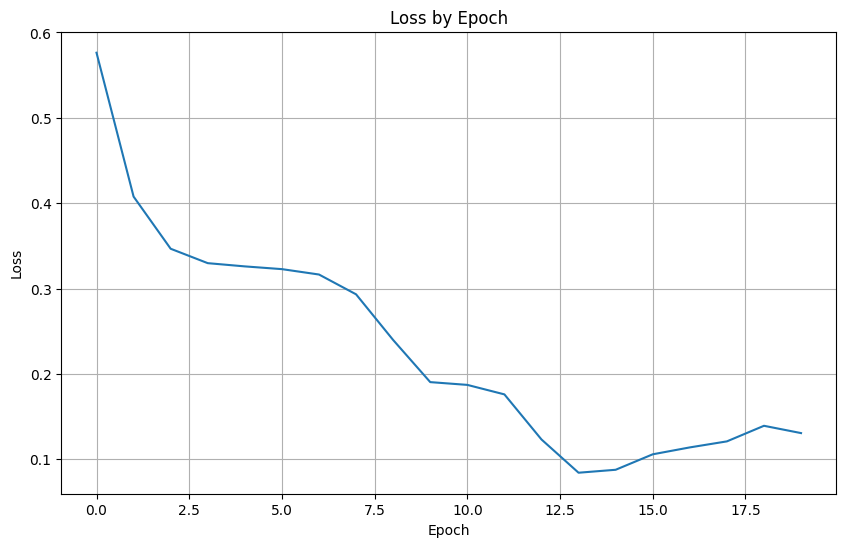

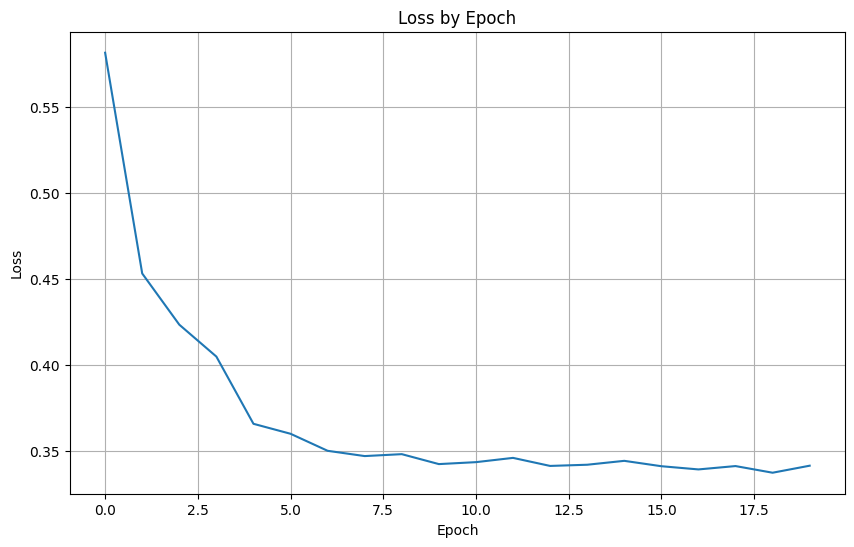

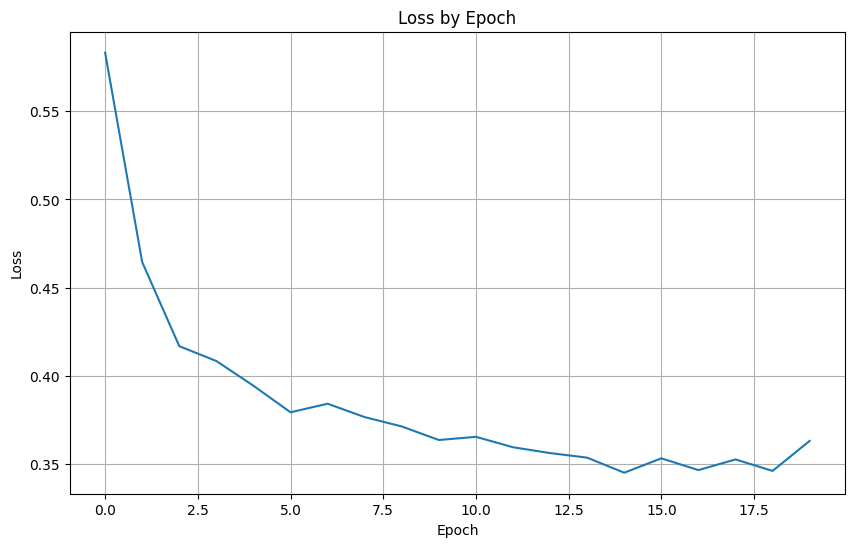

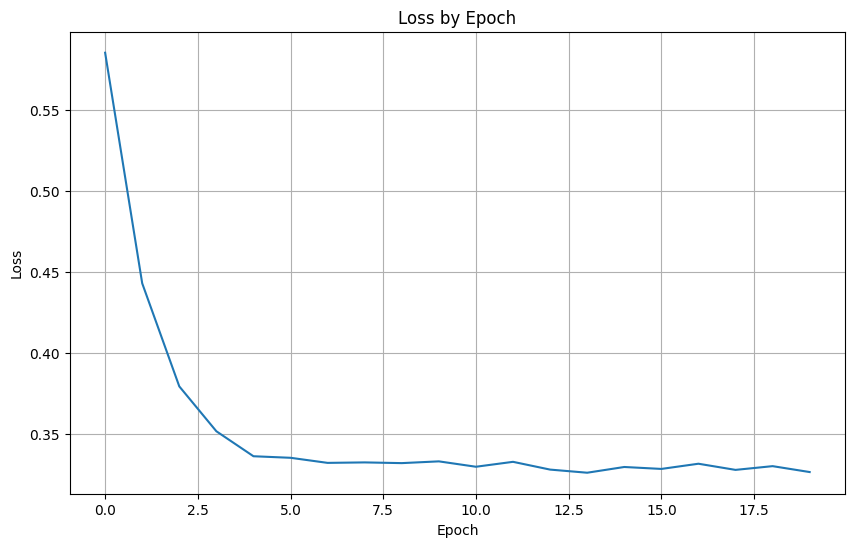

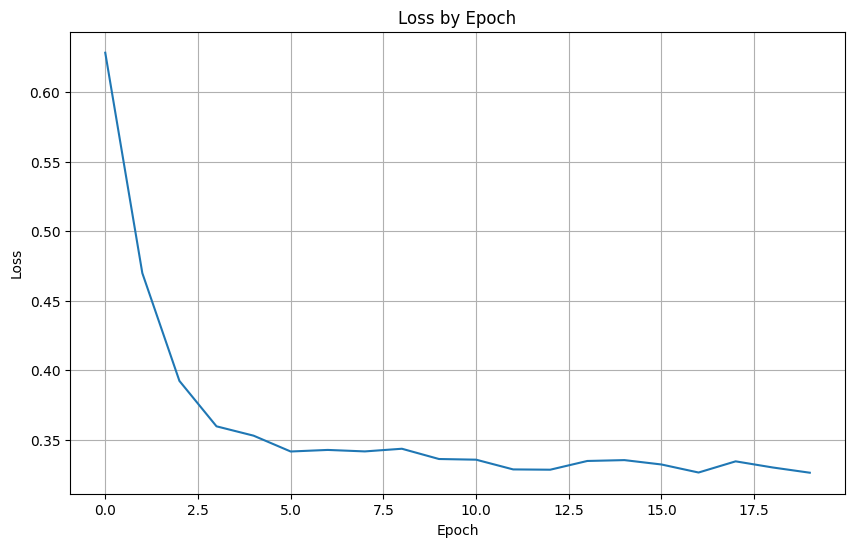

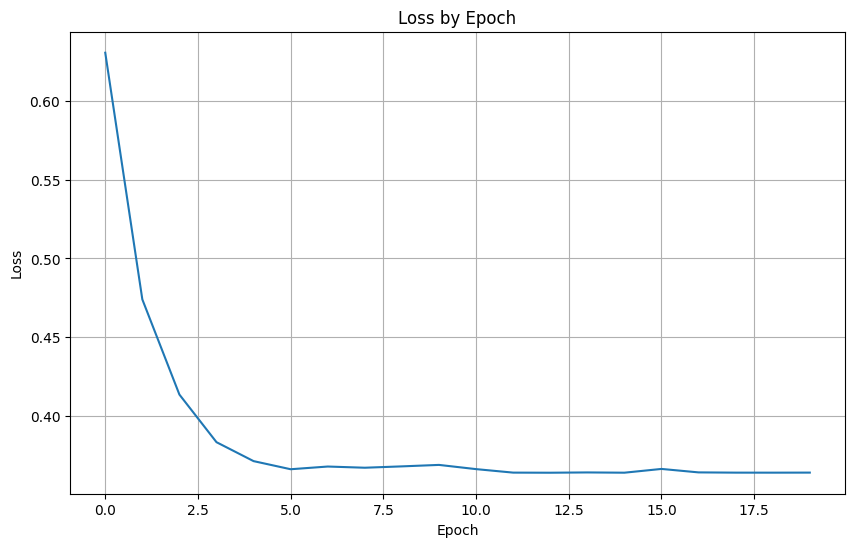

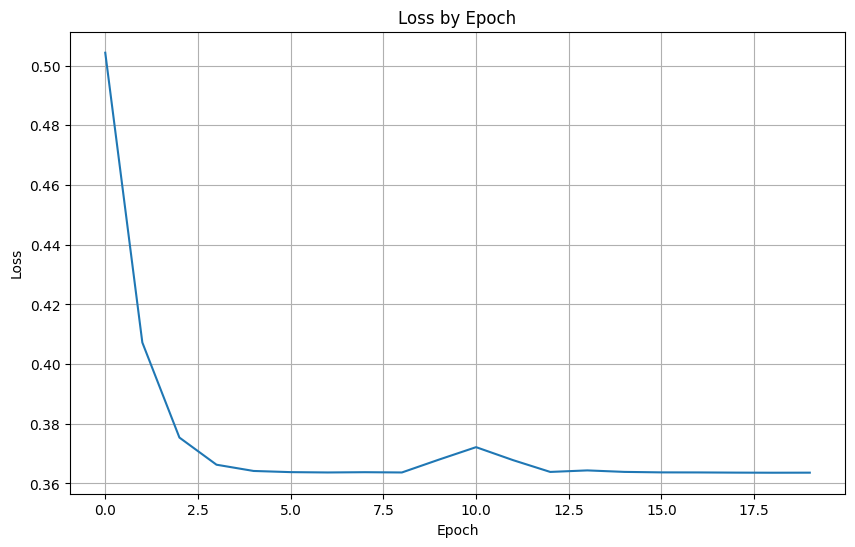

In [32]:
plot_loss(list_loss_bm25)
plot_loss(list_loss_LS_bm25)
plot_loss(list_loss_LS_random)
plot_loss(list_loss_TLS_bm25)
plot_loss(list_loss_TLS_random)
plot_loss(list_loss_WSLS_bm25)
plot_loss(list_loss_TWSLS_bm25)